# The perceptron

Perceptrons, invented in the [1957]( https://en.wikipedia.org/wiki/Perceptron#History) by Frank Rosenblatt, are the simpliest form of feedforward networks. They are [linear classifiers](https://en.wikipedia.org/wiki/Linear_classifier) because they find a linear function to predict if a piece of data belongs to a determined class or not. A perceptron is basically formed by a layer of input units and a layer of output units. In the simpliest case the output layer is formed by just one unit:

![](perceptron.png)

<div>Table of contents</div>
<div id="toc"></div>

### Spreading  of activations
At each timestep of the simulation the first layer of units $\mathbf{x}=[x_0,\dots,x_n]$ is filled up with an input vector $\mathbf{p}_k=[p_{k0},\dots,p_{kn}]$. One unit of this layer, the bias, is not included in this update. instead it is permanently set to 1.
Each connection from a unit of the first layer to the output unit has a weight that is initially set to 0. The activation of the output unit is given by the weighted sum of the input units plus the weighted bias:
$$
y = \sum_{i=1}^{n+1} w_i x_i + w_0
$$
In python you can write:

```python
y = w[0]
for i in xrange(n): 
    y += w[i]*x[i]
```
Using linear algebra we can rewrite it in a shorter form as:
$$
\mathbf{y} = \mathbf{W}\mathbf{\tilde{x}}
$$
where $\mathbf{\tilde{x}} = (1, x_0, \dots, x_n)$ and $\mathbf{W}\mathbf{\tilde{x}}$ is is the [dot product](https://en.wikipedia.org/wiki/Dot_product#Algebraic_definition), a linear algebra operator that allows to calculate the  weighted sum at once.
In python it becomes:

```python
tx = hstack([1, x])
y = dot(w,tx)
```
*Using linear algebra in a neural network implementation is far simpler than writing loops, it is less error prone and also produces a much efficient code in terms of speed!!*

### Learning
Learning consists in updating the weights so that the weighted sum $y$ is more and more similar to a desired output $o_k$ when we give the input $p_k$ to the network.
In perceptrons learning can be done online, meaning that we can update the weights each time a single input pattern is presented.
Learning is given at each timestep by:
$$
\Delta w_i = \eta (o_k - y)\tilde{x}_i
$$
or, in linear algebra notation:
$$
\Delta \mathbf{w} = \eta(o_k - y)\mathbf{\tilde{x}} 
$$
where $\eta$ is a value determining the rate of weight change per timestep (it is typically very little) and $o_k - y$ is the error in reproducing the desired value.
In python we write:
```python
w += eta*(o - y)*tx
```

### The decision boundary
The weights of the network can be viewed as the parameters of a linear equation. This equation defines a boundary in the space of all possible inputs. All points laying above the boundary belong to the class, all the others don't belong to it.
If the network has two inputs plus the bias the input space is a plane and the boundary is a row. In this case it is: 

$$x_2 = -\frac{x_1 w_1 + w_0}{w_2}$$
![](linear.png)




### The error

We can analyze if how much the network has learned by measuring the error. We compute the error at each timestep as the sum of the squares of the errors for each output unit:
$$
E_t = \sum_i \frac{1}{2}(o_i - y_i)^2
$$

If the network is learning the error diminuishes and it converges to a minimum. After a while the error cannot diminuish any more and the network reaches a steady state. 

### A simple simulation

In [1]:
%matplotlib inline
from pylab import *

Let us start by implementing a very simple network. Our network will only have two input units plus a bias unit. 
The network will learn to categorize few different input patterns in two classes:



#### Initializing data and parameters
We create input data with pseudo-random number generation.
We will start from two points, the centroids of the two classes, and create all patterns in each class adding noise to each centroid.

In [2]:
# number of training patterns
np = 400

# Create an array with 2-dimensional patterns 
# belonging to two categories
#
# np:        int                 Number of patterns
# sd:        float               Standard deviation of noise
# centroid1: 2-elements_vector   The point from which the first 
#                                class is generated
# centroid2: 2-elements_vector   The point from which the second 
#                                class is generated
# returns:   array               Each row contains a pattern in
#                                the first two elements and
#                                the class to which it belongs in
#                                the third element
def build_dataset( np = 100, 
                   sd = 0.2,
                   centroid1 = array([-1.2, 1.8]), 
                   centroid2 = array([-0.2, 0.4]) ) :
    
    # Decide to which class patterns will belong.
    # First half belongs to the first class
    categories = 2*(arange(np)/(np/2)) - 1  
    
    # Each row of this array will contain a 2-element-wide 
    # input pattern plus an integer defining to which category
    # the pattern belongs   
    data = zeros([np,3])

    # Iterate the patterns to generate
    for t in xrange(np) :
        
        pattern = zeros(2)
        
        if categories[t] > 0 : 
            pattern = centroid1.copy()
        else :
            pattern = centroid2.copy()
        
        # Add noise to each element of the centroid
        pattern += sd*randn(2)

        # Fill up data 
        data[t,:] = hstack([pattern, categories[t]])
    
    return data

# Training data 
data = build_dataset(np)

# Each row of P is an input pattern
P = data[:,:2]

# limits
upper_bound = P.max(0) + 0.2*(P.max(0)-P.min(0))
lower_bound = P.min(0) - 0.2*(P.max(0)-P.min(0))


# Each element of o is the desired output 
# relative to an input pattern
o = data[:,2]

Let's plot the input points, colors are the categories to which they belong, centroids are the bigger circles:

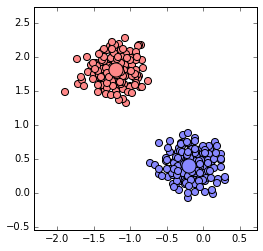

In [3]:
# Create the figure
fig = figure(figsize=(4,4))

scatter(*P[(np/2):,:].T, s = 50,  c = '#ff8888' )
scatter(*P[:(np/2),:].T, s = 50,  c = '#8888ff' )

scatter(-1.2, 1.8, s = 200, c = '#ff8888' )
scatter(-0.2, 0.4, s = 200, c = '#8888ff' )

xlim( [lower_bound[0], upper_bound[0]] )
ylim( [lower_bound[1], upper_bound[1]] )

show()

Now some other initializations:

In [4]:
# Constants

# Number of input elements
n = 2        

# Learning rate
eta = 0.01    

# Number of timesteps
stime = 2000  


# Variables

# Initialize weights
w = zeros(n+1)

# Initialize the weight history storage
dw = zeros([n+1,stime])

# Initialize the error history storage
E = zeros(stime)

#### Spreading of the network during training
Here starts the core part, iterating the timesteps:

In [5]:
# Create a list of pattern indices.
# We will reshuffle it at each 
# repetition of the series
pattern_indices = arange(np)

for t in xrange(stime) :
    
    
    # Reiterate the input pattern 
    # sequence through timesteps
    
    # Reshuffle at the end 
    # of the series
    if t%np == 0:
      shuffle(pattern_indices)
    
    # Current pattern 
    k = pattern_indices[t%np]
    
  

    # MAIN STEP CALCULATIONS
    
    # Bias-plus-input vector
    tx = hstack([1, P[k]])
    
    # Weighted sum - !!dot product!!
    y = dot(w, tx)
    
    # Learning
    w += eta*(o[k] - y)*tx
       
    # Store current weights
    dw[:,t] = w
    
    # Current error
    E[t] = 0.5*(o[k] - y)**2
      

#### Plotting the training history
We can plot the history of the modifications of the decision boundary and the error curve:

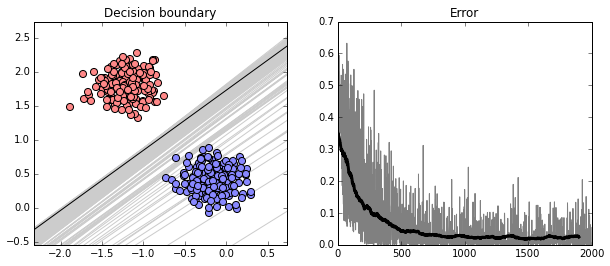

In [6]:
# Create the figure
fig = figure(figsize=(10,4))

# First plot - scatter + decision boundary
subplot(121)

title('Decision boundary')

# Chose the x-axis coords of the
# two points to plot the decision 
# boundary line
x1 = array([lower_bound[0],upper_bound[0]])

# Calculate the y-axis coords of the
# two points to plot the decision 
# boundary line as it changes 
for t in xrange(stime) :
    
    # Show evert 10th timestep
    if t%10 == 0:
        
        # Evaluate x2 based on current weights
        x2 = -(dw[1,t]*x1 + dw[0,t])/dw[2,t]
        
        # Plot
        plot(x1,x2, c='#cccccc', linewidth = 1, zorder = 1)

# Evaluate x2 ibased on final weights
x2 = -(w[1]*x1 + w[0])/w[2]

# Plot
plot(x1,x2, c= '#000000', linewidth = 1, zorder = 1)

# Show points
scatter(*P[:(np/2),:].T, s = 50,  c = '#8888ff', zorder = 2 )
scatter(*P[(np/2):,:].T, s = 50,  c = '#ff8888', zorder = 2 )       

xlim( [lower_bound[0], upper_bound[0]] )
ylim( [lower_bound[1], upper_bound[1]] )

# Second plot - error
subplot(122)

title('Error')

# Plot the error
plot(E,c="gray")

# Plot the moving average of the error
plot(convolve(E, ones((100,))/100, mode='valid'),
     linewidth =3, c="k")

show()

#### Testing

Now we create a new dataset to test the network: 

In [78]:
# Number of test patterns
nt = 200

# Test data - we change the standard deviation 
tests = build_dataset(nt, sd = 0.4 )

# Each row of P is a test pattern
T = tests[:,:2]

# Each element of o is the desired output 
# relative to an input pattern
ot = tests[:,2]

y = zeros(nt)
E = zeros(nt)

# iterate tests
for t in xrange(nt) :
    
    # bias-plus-input vector
    tx = hstack([1, T[t]])
    
    # weighted sum - dot product
    y[t] = dot(w, tx)
    
    # current error
    E[t] = 0.5*(ot[t] - y[t])**2
    


#### Plotting test results
We plot all test patterns using the output of the network to color them. Intens red and blue dots are identified as belonging to a class with a little error, while it is much harder to identify white dots.

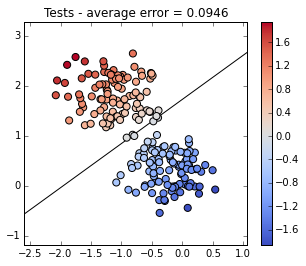

In [79]:
# Evaluate bounds
upper_bound = T.max(0) + 0.2*(T.max(0)-T.min(0))
lower_bound = T.min(0) - 0.2*(T.max(0)-T.min(0))

# Create the figure
fig = figure(figsize=(5,4))


title('Tests - average error = {}'.format(mean(E).round(4)))

# Chose the x-axis coords of the
# two points to plot the decision 
# boundary line
x1 = array([lower_bound[0],upper_bound[0]])

# Calculate the y-axis coords of the
# two points to plot the decision 
# boundary line

# Evaluate x2 based on final weights
x2 = -(w[1]*x1 + w[0])/w[2]

# Plot
plot(x1,x2, c= '#000000', linewidth = 1, zorder = 1)

# Show points
ax = scatter(*T.T, s = 50,  c = y, zorder = 2, cmap = cm.coolwarm )
colorbar(ax)

#limits
xlim( [lower_bound[0], upper_bound[0]] )
ylim( [lower_bound[1], upper_bound[1]] )

show()

### Recognising the MNIST digits

Let us implement a perceptron that categorize the MNIST images as numbers.

#### Initialize the dataset
First we initialize the dataset:

In [9]:
# Download the dataset 

# Get the script from internet
! wget https://raw.githubusercontent.com/sorki/python-mnist/master/get_data.sh > /dev/null 2>&1  

# Run it to dovnload all files in a local dir named 'data'
! bash get_data.sh >/dev/null 2>&1

# We do not need the script anymore, remove it
! rm get_data.sh* > /dev/null 2>&1



# Initialize the dataset variables
%run utils

We now fill a array with all parameters. We will take the first 50 digits in the training set.

In [10]:
# Set the number of patterns 
n_patterns = 50

# Take 'n_patterns' rows
patterns = array(mndata.train_images)[:n_patterns]

# Rescale all patterns between 0 and 1
patterns = sign(patterns/255.0)

# Get the labels of the patterns
labels = array(mndata.train_labels)[:n_patterns]

Let us visualize the first 20 patterns:

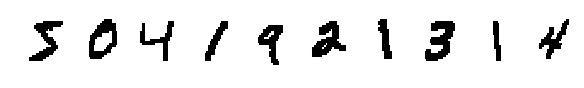

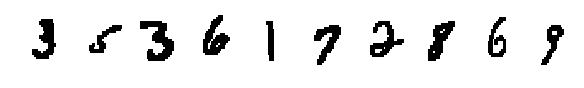

In [11]:
for i in xrange(20):
    # Create a new figure after each 10-th item
    if i%10 == 0:
        fig = figure(figsize = (20, 1))
    
    # Plot current item (we use the 
    # function plot_img in our utils.py)
    plot_img( to_mat(patterns[i]), 
        fig, (i%10)+1, windows = 20 )
    
    # show figure after all 1o items
    # are plotted
    if i%10 == 9:
        show()

#### Iterating the timesteps

Now we implement the core part, defining what happens in each timestep.

> Note that now when we compute the activations we multiply a matrix $\mathbf{W}$ times a vector $\mathbf{tx}$. $\mathbf{W}\cdot\mathbf{tx}$ is the [matrix product](https://en.wikipedia.org/wiki/Matrix_multiplication#Matrix_product_.28two_matrices.29) of which the dot product is a [special case](https://en.wikipedia.org/wiki/Matrix_multiplication#Row_vector_and_column_vector).

In [9]:
# Constants

# Number of trials for learning
trials = 10*n_patterns

# Create a list of pattern indices.
# We will reshuffle it at each 
# repetition of the series
pattern_indices = arange(n_patterns)

# Learning rate
eta = 0.01

# Number of output unit 
# (remember that the input is given
# by a 28*28 vector)
m = 10

# Variables 

# Init weights
w = zeros([m, n+1])

# Init input units
x = zeros(n)

# Init output units
y = zeros(m)

# Init desired output vector
y_target = zeros(m)


# We will store the input, output and error history
input_store = zeros([n,trials])
output_store = zeros([m,trials])
E = zeros(trials)


# Iterate trials
for t in xrange(trials) :
    
    # Reiterate the input pattern 
    # sequence through timesteps
    
    # Reshuffle at the end 
    # of the series
    if t%n_patterns == 0:
        shuffle(pattern_indices)
    
    # Current pattern 
    k = pattern_indices[t%n_patterns]
    
    # Aggregate inputs and the bias unit
    x = hstack([ 1, patterns[k] ])
    
    # Only the unit representing the desired 
    # category is set to 1
    y_target *= 0
    y_target[labels[k]] = 1
    
    # !!!! The dot product becomes a matrix 
    # product with more than one output unit !!!!
    y = dot(w,x) 
    
    # Learning - outer product
    w += eta*outer(y_target - y, x);
    
    # Store data
    input_store[:,t] = x[1:]
    output_store[:,t] = y
    E[t] = 0.5*sum((y_target - y)**2)
    

NameError: name 'n_patterns' is not defined

#### Plotting
We will create an animation showing the network learning to categorize the digits as numbers:

In [10]:
# The matplotlib object to do animations
from matplotlib import animation

# This grid allows to layout subplots in a more
# flexible way
import matplotlib.gridspec as gridspec

# Initialize the figure for the animation    
# target_index :  int     The index of the target 
#                         to plot
# returns      :  tuple   The three plotting objects 
#                         to render       
def init_fig(timestep = 0, plot_error = True) :    

    # This is the input digit
    input_digit = input_store[:,timestep]
    
    # This is the ioutput of the network 
    # (10-elements vector)
    output = output_store[:,timestep]
   
    # Init the grid and the figure
    gs = gridspec.GridSpec(8, 24)
    fig = figure(figsize=(10, 4.5))        

    #-------------------------------------------------
    # Plot 1 - plot the input digit
   
    # Create subplot
    ax1 = fig.add_subplot(gs[:4,:4])
    
    title("input")
    
    # Create the imshow and save the handler
    im_input = ax1.imshow(to_mat(input_digit), 
                          interpolation = 'none', 
                          aspect = 'auto',
                          cmap = cm.binary) 
    # Further plot specs
    axis('off')

    
    #-------------------------------------------------
    # Plot 2 - plot the current state of the network
    
    # Create subplot
    ax2 = fig.add_subplot(gs[:4,6:14])
    
    title("output vector")
    
    # Create the imshow and save the handler
    im_output = ax2.bar(arange(m),output) 

    # Only bottom axes
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax2.set_xticks(arange(m)+.5)
    ax2.set_xticklabels(arange(m))
    ax2.set_yticks([])
    # Further plot specs
    ylim([-.5,1])
 
    
    # Plot 3 - plot the current history of error
    im_E = None
    # Only plot if plot_error flag is set
    if plot_error == True :
        
        # Create subplot
        ax3 = fig.add_subplot(gs[:4,16:])
        
        title("Error")
        
        # Create the line plot and save the handler
        im_E, = ax3.plot(E[timestep])
        
        # Only bottom-left axes - no tics
        ax3.spines['top'].set_visible(False)
        ax3.spines['right'].set_visible(False)
        ax3.set_xticks([])
        ax3.set_yticks([])
        
        # Further plot specs
        xlim([0,trials])
        ylim([0,2])
    
    # Return the handlers
    return fig,im_input,im_output,im_E

# Updates images at each frame of the animation
# data    : list of tuples    Each row contains the
#                             arguments of update for 
#                             a frame
# returns : tuple             The handlers of the 
#                             images                   
def update(data) :

    # Unpack data
    input_digit,output,E = data
    
    # Update data of plot1,  2 and 3
    im_input.set_array(to_mat(input_digit))
    
    # set data of the 2nd plot
    # (change height of each bar)
    for rect, h in zip(im_output, output ) :
        rect.set_height(h)
    
    # set data of the 3rd plot
    im_E.set_xdata(arange(len(E)))
    im_E.set_ydata(E)
    
    # Return the handlers
    return im_input,im_output,im_E

In [11]:
# Our function to render videos inline 
# (see anim_to_html.py)
import anim_to_html as AH

# The first pattern
# initialize the figure
fig, im_input, im_output, im_E = init_fig()

# We use a generator (see https://goo.gl/ekU3u2) to Build 
# the sequence of update arguments for pattern 0.
# each row of the list contains the activation vector at a 
# timestep and a vector storing the energy story up to 
# that timestep. 
data = [ ( input_store[:,t], output_store[:,t], E[:(t+1)] ) 
    for t in xrange(trials) ]

# Create and render the animation
anim = animation.FuncAnimation(fig, update, data)
AH.display_animation(anim)

NameError: global name 'input_store' is not defined

#### Test
Finally we test the network on new items taken from the test dataset:

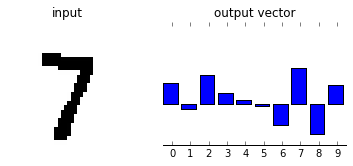

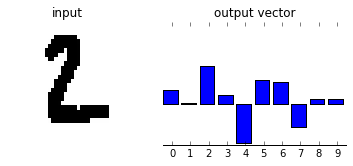

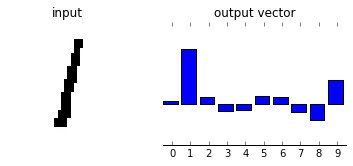

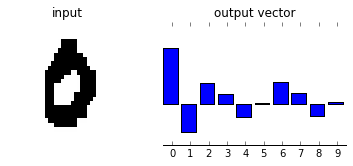

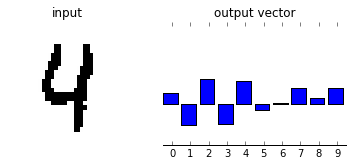

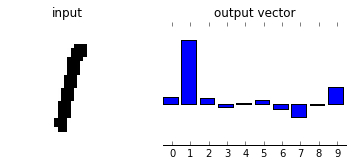

In [15]:
# Set the number of patterns 
n_patterns = 6

# Take 'n_patterns' rows
patterns = array(mndata.test_images)[:n_patterns]

# Rscale all patterns between 0 and 1
patterns = sign(patterns/255.0)

# Get the labels of the patterns
labels = array(mndata.train_labels)[:n_patterns]



for p in xrange(n_patterns) :

    # Aggregate inputs and the bias unit
    x = hstack([ 1, patterns[p] ])
       
    # !!!!the dot product becomes a matrix 
    # product with more than one output unit!!!!
    y = dot(w,x) 
 
    # init the stores to be used wit init_fig()
    input_store = zeros([n,1])
    output_store = zeros([m,1])   
    
    # fill-up stores
    input_store[:,0] = x[1:]
    output_store[:,0] = y
    
    # call init_fig to plot the current test
    init_fig(timestep = 0, plot_error = False) 

<br><br><br><br><br><br><br><br><br><br><br><br><br><br>
<br><br><br><br><br><br><br><br><br><br><br><br><br><br>
<br><br><br><br><br><br><br><br><br><br><br><br><br><br>
The next cell is just for styling

In [12]:
from IPython.core.display import HTML
def css_styling():
    styles = open("../style/ipybn.css", "r").read()
    return HTML(styles)
css_styling()